In [20]:
import tensorflow as tf

In [19]:
from tensorflow.examples.tutorials.mnist import input_data

DATA_DIR = '/tmp/data'
NUM_STEPS = 1000
MINIBATCH_SIZE = 100

data = input_data.read_data_sets(DATA_DIR, one_hot=True)

x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784,10]))

y_true = tf.placeholder(tf.float32, [None, 10])
y_pred = tf.matmul(x, W)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

gd_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for _ in range(NUM_STEPS):
        batch_xs, batch_ys = data.train.next_batch(MINIBATCH_SIZE)
        sess.run(gd_step, feed_dict={x: batch_xs, y_true: batch_ys})
        
    ans = sess.run(accuracy, feed_dict={x: data.test.images, y_true: data.test.labels})

print 'Accuracy: {:.4}%'.format(ans*100)  

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Accuracy: 91.6%


# Importing Images

Read more queues and threads here: https://blog.metaflow.fr/tensorflow-how-to-optimise-your-input-pipeline-with-queues-and-multi-threading-e7c3874157e0

This portion uploads all images in working directory into filename_queue  
Decodes the image data into RGB numbers  
Resizes the images to the same size  

Next: tf.train.batch?   
why does it only output one image rather than the two

['./Abudefduf_Abudefduf bengalensis_880932306.jpg'
 './Chrysiptera_Chrysiptera cyanea_-1721372500.jpg']
Tensor("ReaderReadV2_18:1", shape=(), dtype=string)
(256, 256, 3)
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, assertion failed: [string_input_producer requires a non-null input tensor]
	 [[Node: input_producer_2/Assert/Assert = Assert[T=[DT_STRING], summarize=3, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer_2/Greater, input_producer_2/Assert/Assert/data_0)]]


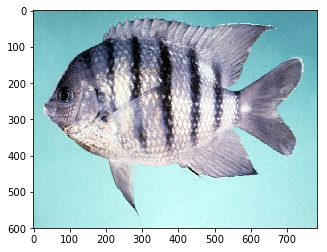

In [29]:
import matplotlib.pyplot as plt

directory = "*.jpg" 
filenames = tf.train.match_filenames_once(directory) #match all the filenames in the directory
filename_queue = tf.train.string_input_producer(filenames) #add the files to the filename_queue
reader = tf.WholeFileReader()
filename, content = reader.read(filename_queue)
image = tf.image.decode_jpeg(content, channels=3)
image = tf.cast(image, tf.float32) / 255.0
resized_image = tf.image.resize_images(image, [256, 256])

#image_batch = tf.train.batch([resized_image], batch_size=9)
init = (tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(filenames))
    print(filename_queue)
    print(content)
    print(resized_image.shape)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    plt.imshow(image.eval())
    plt.show()
    
    #coord.request_stop()
    #coord.join(threads)
    

# Convolutional Neural Net

Used http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/ as a base

In [75]:
import tensorflow as tf
import glob
import cv2
import numpy as np

def create_new_conv_layer(input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels,
                      num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                      name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

    # add the bias
    out_layer += bias

    # apply a ReLU non-linear activation
    out_layer = tf.nn.relu(out_layer)

    # now perform max pooling
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 2, 2, 1]
    out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, 
                               padding='SAME')

    return out_layer

In [76]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [77]:
images = glob.glob('*.jpg')
images.sort()
images

['eyespot_Abudefduf_Abudefduf sparoides_929157376.jpg',
 'eyespot_Acanthurus_Acanthurus tennentii_-1986886053.jpg',
 'eyespot_Acanthurus_Acanthurus thompsoni_-1325670399.jpg',
 'eyespot_Amblycirrhitus_Amblycirrhitus bimacula_-2115602772.jpg',
 'eyespot_Amblycirrhitus_Amblycirrhitus bimacula_1677061943.jpg',
 'eyespot_Apogon_Apogon cavitiensis_-1692469642.jpg',
 'eyespot_Apogon_Apogon endekataenia_725932159.jpg',
 'eyespot_Apogon_Apogon melas_1761120890.jpg',
 'eyespot_Apogon_Apogon nigrofasciatus_-2146149423.jpg',
 'eyespot_Bodianus_Bodianus diana_1512476701.jpg',
 'eyespot_Centropyge_Centropyge multispinis_-1761499235.jpg',
 'eyespot_Centropyge_Centropyge narcosis_-1843367047.jpg',
 'eyespot_Centropyge_Centropyge nigriocellus_414384710.jpg',
 'eyespot_Chaetodon_Chaetodon excelsa_853070272.jpg',
 'eyespot_Chaetodon_Chaetodon ulietensis_-1430510223.jpg',
 'eyespot_Chaetodon_Chaetodon zanzibariensis_-1292827274.jpg',
 'eyespot_Chrysiptera_Chrysiptera biocellata_-1668359301.jpg',
 'eyespo

In [78]:
train = []
for img in images:
    newimg = cv2.imread(img)
    newimg = cv2.cvtColor( newimg, cv2.COLOR_RGB2GRAY )
    newimg = cv2.resize(newimg, (28,28))
    newimg = newimg/255.0
    newimg = np.reshape(newimg, 784, order ="A")
    train.append(newimg)
train[0].shape


(784,)

have to edit this piece; labels should be in the form of [0,1] or [1,0] to indicate what it is  
have to afterwards edit the y placeholder and inputs in the training code

In [106]:

labels_x = np.repeat([[1,0],40)
labels_y = np.repeat([0,1], 40)
labels = np.concatenate((labels_x, labels_y))
labels_x

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [80]:
test = []
test.append(train[0])
test.append(train[1])
test.append(train[2])
test.append(train[79])
test.append(train[78])
test.append(train[77])
len(test)

test_labels = np.array(("eyespots","eyespots","eyespots","noeyespots","noeyespots","noeyespots"))
test_labels

array(['eyespots', 'eyespots', 'eyespots', 'noeyespots', 'noeyespots',
       'noeyespots'], dtype='|S10')

In [81]:
train = np.delete(train,0,0)
train = np.delete(train,0,0)
train = np.delete(train,0,0)

train = np.delete(train,74,0)
train = np.delete(train,74,0)
train = np.delete(train,74,0)
len(train)


74

In [82]:
# Python optimisation variables
learning_rate = 0.0001
epochs = 10
batch_size = 10

# declare the training data placeholders
# input x - for 28 x 28 pixels = 784 - this is the flattened image data that is drawn from 
# mnist.train.nextbatch()
x = tf.placeholder(tf.float32, [None, 784])
# dynamically reshape the input
x_shaped = tf.reshape(x, [-1, 28, 28, 1])
# now declare the output data placeholder - 10 digits
y = tf.placeholder(tf.float32, [None, 10])

In [83]:
# create some convolutional layers
layer1 = create_new_conv_layer(x_shaped, 1, 32, [5, 5], [2, 2], name='layer1')
layer2 = create_new_conv_layer(layer1, 32, 64, [5, 5], [2, 2], name='layer2')

In [84]:
flattened = tf.reshape(layer2, [-1, 7 * 7 * 64])

In [85]:
wd1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1000], stddev=0.03), name='wd1')
bd1 = tf.Variable(tf.truncated_normal([1000], stddev=0.01), name='bd1')
dense_layer1 = tf.matmul(flattened, wd1) + bd1
dense_layer1 = tf.nn.relu(dense_layer1)

In [86]:
# another layer with softmax activations
wd2 = tf.Variable(tf.truncated_normal([1000, 10], stddev=0.03), name='wd2')
bd2 = tf.Variable(tf.truncated_normal([10], stddev=0.01), name='bd2')
dense_layer2 = tf.matmul(dense_layer1, wd2) + bd2
y_ = tf.nn.softmax(dense_layer2)

In [87]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=dense_layer2, labels=y))

In [103]:
# add an optimiser
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# setup the initialisation operator
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    total_batch = int(len(train) / batch_size)
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x, batch_y = next_batch(batch_size, train, labels)
            batch_y = batch_y[np.newaxis]
            _, c = sess.run([optimiser, cross_entropy], 
                            feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        test_acc = sess.run(accuracy, 
                       feed_dict={x: test, y: test_labels})
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), "test accuracy: {:.3f}".format(test_acc))

    print("\nTraining complete!")
    print(sess.run(accuracy, feed_dict={x: test, y: test_labels}))


InvalidArgumentError: logits and labels must be same size: logits_size=[10,10] labels_size=[1,10]
	 [[Node: SoftmaxCrossEntropyWithLogits_2 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Reshape_12, Reshape_13)]]

Caused by op u'SoftmaxCrossEntropyWithLogits_2', defined at:
  File "/Users/leannwoo/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/leannwoo/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 1065, in start
    handler_func(fd_obj, events)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-87-9ac016284921>", line 1, in <module>
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=dense_layer2, labels=y))
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1783, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 4364, in _softmax_cross_entropy_with_logits
    name=name)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/leannwoo/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[10,10] labels_size=[1,10]
	 [[Node: SoftmaxCrossEntropyWithLogits_2 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Reshape_12, Reshape_13)]]
